In [27]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)
model.export(format='engine', device='cuda', batch=16)

Ultralytics 8.3.186  Python-3.12.4 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

PyTorch: starting from 'yolov8n.pt' with input shape (16, 3, 640, 640) BCHW and output shape(s) (16, 84, 8400) (6.2 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.65...
ONNX: export success  3.6s, saved as 'yolov8n.onnx' (12.2 MB)

TensorRT: starting export with TensorRT 10.10.0.31...
TensorRT: input "images" with shape(16, 3, 640, 640) DataType.FLOAT
TensorRT: output "output0" with shape(16, 84, 8400) DataType.FLOAT
TensorRT: building FP32 engine as yolov8n.engine
TensorRT: export success  385.4s, saved as 'yolov8n.engine' (18.8 MB)

Export complete (388.1s)
Results saved to C:\Users\Ayaan\Desktop\All Projects Folder\cnn_can_see_plus_daily_ds
Predict:         yolo predict task=detect model=yolov8n.engine imgsz=640  
Validate:        yolo val task=detect mode

'yolov8n.engine'

In [7]:
from ultralytics import YOLO 
model_engine = YOLO("yolov8n.engine") 



WARNING Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.


In [8]:
import torch
torch.cuda.empty_cache()

In [3]:
import torch 
free , total = torch.cuda.mem_get_info()
print(torch.cuda.memory_summary())
print(f"Free Memory: {free / 1024**2:.2f} MB")
print(f"Total Memory: {total / 1024**2:.2f} MB")

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [2]:
torch.cuda.empty_cache() 

In [ ]:

import urllib.request
import zipfile
import os
url = "http://images.cocodataset.org/zips/val2017.zip"
zip_path = "val2017.zip"
if not os.path.exists(zip_path):
    print("Downloading val2017.zip ...")
    urllib.request.urlretrieve(url, zip_path)
    print("Download complete.")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    print("Extracting val2017.zip ...")
    zip_ref.extractall("val2017")
    print("Extraction complete.")

Download complete.
Extracting val2017.zip ...
Extraction complete.


device: cuda
found image files: 5000
example: ['val20171\\000000000139.jpg', 'val20171\\000000000285.jpg', 'val20171\\000000000632.jpg', 'val20171\\000000000724.jpg', 'val20171\\000000000776.jpg']
loaded counts -> tensors: 128 , images: 128
vis image type/shape: <class 'numpy.ndarray'> (640, 640, 3)
tensor type/shape: <class 'torch.Tensor'> torch.Size([3, 640, 640])


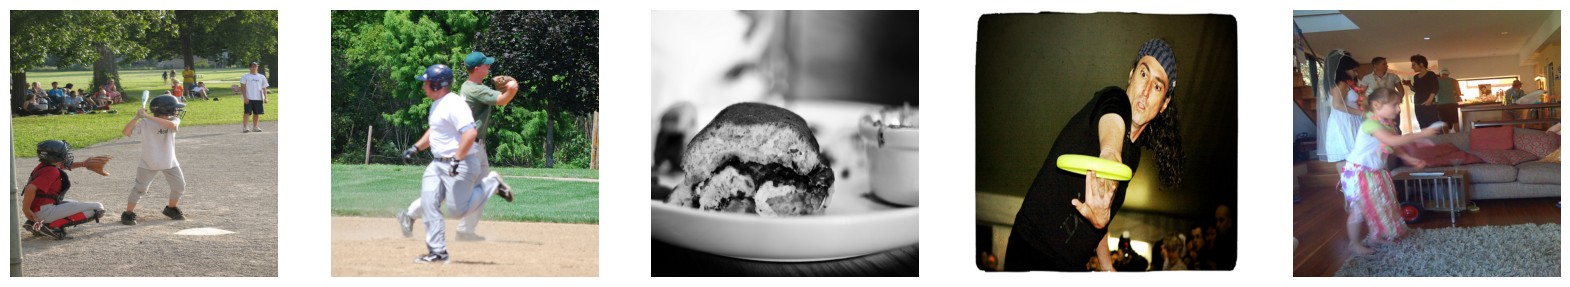

In [ ]:
%matplotlib inline
import os, random, cv2, torch, numpy as np, matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)
image_dir = 'val20171' 
valid_exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")

def find_image_paths(root_dir):
    if not os.path.exists(root_dir):
        print("image_dir does not exist:", root_dir)
        return []
    paths = []
    for root, _, files in os.walk(root_dir):
        for f in files:
            if f.lower().endswith(valid_exts):
                paths.append(os.path.join(root, f))
    return sorted(paths)

def prepare_images(image_paths, device, max_images=128):
    tensors = []   
    vis_images = []          # visualization: numpy arrays (H,W,C) uint8 on CPU (RGB)
    for p in image_paths[:max_images]:
        img = cv2.imread(p)  # BGR uint8 or None
        if img is None:
            print("cv2.imread returned None for:", p)
            continue
        try:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB uint8
        except Exception as e:
            print("cvtColor failed for:", p, "->", e)
            continue
        img_resized = cv2.resize(img_rgb, (640, 640))
        # model tensor: C,H,W, float [0,1]
        tensor = torch.from_numpy(img_resized).permute(2, 0, 1).to(device).float() / 255.0
        tensors.append(tensor)
        vis_images.append(img_resized)  # keep as HWC uint8 for plotting
    return tensors, vis_images

def show_images_matplotlib(vis_images, num_of_image=5):
    n = min(num_of_image, len(vis_images))
    if n == 0:
        print("No images to show.")
        return
    imgs = random.sample(vis_images, n)
    plt.figure(figsize=(4*n, 4))
    for i, img in enumerate(imgs):
        plt.subplot(1, n, i + 1)
        plt.imshow(img)   # img is H x W x C (RGB uint8)
        plt.axis('off')
    plt.show()

# --- run loader + show ---
paths = find_image_paths(image_dir)
print("found image files:", len(paths))
if len(paths) > 0:
    print("example:", paths[:5])
tensors, images = prepare_images(paths, device, max_images=128)
print("loaded counts -> tensors:", len(tensors), ", images:", len(images))

# quick debug shape/type check (if any loaded)
if len(images) > 0:
    print("vis image type/shape:", type(images[0]), images[0].shape)      # numpy (H,W,C)
if len(tensors) > 0:
    print("tensor type/shape:", type(tensors[0]), tensors[0].shape)      # torch (C,H,W)

show_images_matplotlib(images, num_of_image=5)


In [28]:
import time
def run_inference(model , images):
    times = []
    results =[]
    for image in images:
        start_time = time.time()

        with torch.no_grad():
            output = model(image)
        end_time = time.time()
        times.append(end_time - start_time)
        results.append(output)
    return results, times

In [30]:
num_trials = 10
average_times = []
for i in range(num_trials):
    results, times = run_inference(model_engine, images)
    average = sum(times) / len(times)
    print(f"Trial {i+1}: Average inference time per image: {average:.4f} seconds")
    average_times.append(average)
mat = sum(average_times) / num_trials
print("Mean average time inference (s)" , mat)


0: 640x640 2 chairs, 1 potted plant, 1 dining table, 1 tv, 2 vases, 68.5ms
Speed: 917.2ms preprocess, 68.5ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bear, 68.6ms
Speed: 7.1ms preprocess, 68.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bottle, 1 chair, 2 potted plants, 1 bed, 68.6ms
Speed: 7.0ms preprocess, 68.6ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 stop signs, 61.0ms
Speed: 6.1ms preprocess, 61.0ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 60.0ms
Speed: 6.0ms preprocess, 60.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 skis, 60.1ms
Speed: 5.7ms preprocess, 60.1ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 oven, 1 refrigerator, 25.4ms
Speed: 4.5ms preprocess, 25.4ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

0: 6